# Trace, extract and calibrate long-slit spectrum

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
__main__ = 'EasyExtract'
__author__ = 'Pascal Louis <plouis35@gmail.com>'
__version__ = '1.1'
__keywords__ = ['astronomy', 'spectroscopy', 'astropy', 'specutils', 'specreduce', 'matplotlib']


## Create logger

In [3]:
import sys
import logging

### logger prints after every notebook cell
logging.basicConfig(
    format='%(asctime)s [%(levelname)s] - %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    stream=sys.stdout,
)
logger = logging.getLogger('notebook')


## Imports libs

In [4]:
### matplotlib settings
import matplotlib.pyplot as plt

%config InlineBackend.rc = {}
plt.style.use(['dark_background'])
plt.rcParams.update({'figure.max_open_warning': 0}) 

### set the mpl backend
#%matplotlib widget
%matplotlib widget

import warnings, fnmatch, os
from time import gmtime, strftime
from pathlib import Path

import numpy as np

from astropy.table import Table, QTable
from astropy import units as u
from astropy.nddata import CCDData, StdDevUncertainty
from astropy.stats import mad_std
from astropy.io import fits
from astropy.utils.exceptions import AstropyWarning
from astropy.modeling import models, fitting
from astropy.coordinates import get_sun, AltAz, EarthLocation
from astropy.coordinates import SpectralCoord, SkyCoord
from astropy.time import Time
from astropy.nddata import StdDevUncertainty
from astropy.wcs import WCS
from astropy.convolution import Box1DKernel
from specutils.fitting import fit_generic_continuum

#from ccdproc import Combiner, combine, subtract_bias, subtract_dark, flat_correct
#from ccdproc import trim_image, Combiner, ccd_process, cosmicray_median

from specutils import Spectrum1D, SpectralRegion
from specutils.manipulation import median_smooth, gaussian_smooth
from specutils.manipulation import extract_region, gaussian_smooth, convolution_smooth, median_smooth

from specreduce.tracing import FlatTrace, FitTrace
from specreduce.background import Background
from specreduce.extract import BoxcarExtract
from specreduce.fluxcal import FluxCalibration
from specreduce import WavelengthCalibration1D
from specreduce.calibration_data import load_MAST_calspec, load_onedstds

from align_combine import align_and_combine

warnings.simplefilter('ignore', category=AstropyWarning)
warnings.simplefilter('ignore', UserWarning)

from importlib.metadata import version  
for module in ['matplotlib', 'numpy', 'astropy', 'specutils', 'specreduce', 'ccdproc']:
    try:
        logger.info(f"{module} = {version(module)}")
    except Exception as e:
        logger.info(f"{e}")

2025-02-25 17:22:00 [INFO] - matplotlib = 3.9.2
2025-02-25 17:22:00 [INFO] - numpy = 2.1.2
2025-02-25 17:22:00 [INFO] - astropy = 6.1.4
2025-02-25 17:22:00 [INFO] - specutils = 1.18.0
2025-02-25 17:22:00 [INFO] - specreduce = 1.4.1
2025-02-25 17:22:00 [INFO] - ccdproc = 2.4.2


## Define target

In [5]:
import sys
import logging

logging.basicConfig(
    format='%(asctime)s [%(levelname)s] - %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    stream=sys.stdout,
)
logger = logging.getLogger('notebook')

In [6]:
### Observatory location
# CALC
#OBS_LATITUDE = 47.89
#OBS_LONGITUDE = -1.50
#ALTITUDE: 50

#OHP
#OBS_LATITUDE = 43.931
#OBS_LONGITUDE = 5.712
#ALTITUDE: 600

#Void
OBS_LONGITUDE = 5.622875
OBS_LATITUDE = 48.686385
ALTITUDE = 250

### science target
CAPTURE_DIR='../../../CAPTURES/20161200_CHATEAU_TIPE/spectro_TIPE_bruts/'
#TARGET = 'ngc4151'
TARGET = 'markab'
#REFERENCE_STAR = 'delumi_stis_004.fits'             # CALSPEC
REFERENCE_STAR = 'hd158485_stis_007.fits'             # CALSPEC
WAVE_RANGE = 3000, 9000
MEDIAN_SMOOTH = 3
#calib_x_pixel  = 78.099, 128.005, 200.651, 339.185, 468.038, 550.164, 617.539, 677.917, 796.963
#calib_x_wavelength  = 4500.9, 4671.2, 4916.5, 5400.5, 5852.5, 6143.0, 6382.9, 6598.9, 7032.4

WAVELENGTH = [4500.9, 4671.2, 4916.5, 5400.5, 5852.5, 6143.0, 6382.9, 6598.9, 7032.4]*u.AA
PIXELS = [78.099, 128.005, 200.651, 339.185, 468.038, 550.164, 617.539, 677.917, 796.963]*u.pix

#WAVELENGTH = [6506.53, 6532.88, 6598.95, 6678.28, 6717.04]*u.AA
#PIXELS = [770, 1190, 2240, 3484, 4160]*u.pix


## Create spectrum

### Extract science spectrum

2025-02-25 17:22:25 [INFO] - extracting science spectra...
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2025-02-25 17:22:25 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2025-02-25 17:22:25 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
2025-02-25 17:22:25 [INFO] - Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
            c0                   c1                     c2          
    ------------------ ---------------------- ----------------------
    326.30066053969915 -0.0022633774189433583 -9.847677255957812e-07


Text(0, 0.5, 'ADU')

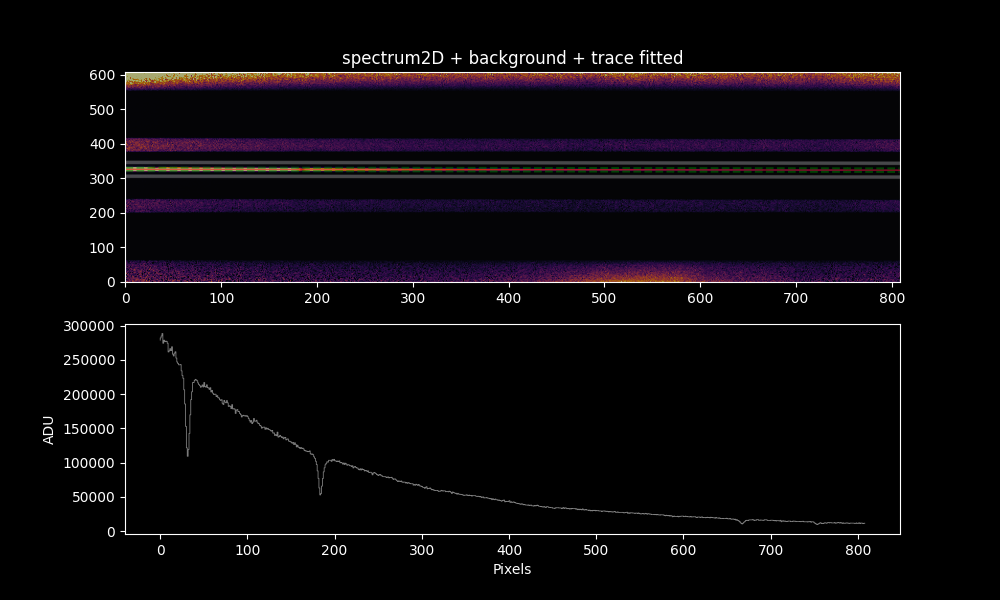

In [8]:
logger.info('extracting science spectra...')

master_science = CCDData.read(CAPTURE_DIR + TARGET + '-reduced.fit', unit = u.adu)
#master_science = CCDData.read(CAPTURE_DIR + TARGET + '-reduced-cosmics' + '.fit', unit = u.adu)
master_calib = CCDData.read(CAPTURE_DIR + 'mastercalib.fit', unit = u.adu)

#sci_tr = tracing.FlatTrace(master_science, 407)
sci_tr = FitTrace(master_science,  
                          bins = 12, 
                          trace_model = models.Polynomial1D(degree=2),
                          peak_method = 'gaussian', 
                          window = 20,
                          #guess=281
                         ) 
#trace_model : one of Chebyshev1D, Legendre1D, Polynomial1D, or Spline1D
#peak_method : One of gaussian, centroid, or max. gaussian

logger.info(sci_tr.trace_model_fit)

cuts = (5,99) #(5, 95.0)
ax0, ax1 = plt.subplots(2, 1, figsize = (10,6))[1]
#plt.tight_layout()
im = ax0.imshow(master_science, origin='lower', aspect='auto', cmap=plt.cm.inferno)

bg = Background.two_sided(master_science, sci_tr, separation=20, width=10) 
extract = BoxcarExtract(master_science - bg, sci_tr, width = 5)
sci_spectrum = extract()

ax0.imshow(bg.bkg_wimage, origin='lower', aspect='auto', cmap=plt.cm.gray, alpha=0.3)
ax0.imshow(sci_tr.image.data, origin='lower', aspect='auto', cmap=plt.cm.gray, alpha=0.1)
im.set_clim(np.percentile(master_science, cuts))

ax0.step(sci_spectrum.spectral_axis, sci_tr.trace , color='red', linewidth = '1.0', alpha=0.5)
ax0.step(sci_spectrum.spectral_axis, sci_tr.trace + extract.width , color='g', linestyle='dashed', alpha=0.5)
ax0.step(sci_spectrum.spectral_axis, sci_tr.trace - extract.width , color='g', linestyle='dashed', alpha=0.5)
ax0.set_title('spectrum2D + background + trace fitted')

ax1.step(sci_spectrum.spectral_axis , sci_spectrum.flux, color='grey', linewidth = '0.6')
ax1.set_xlabel('Pixels')
ax1.set_ylabel('ADU')


### Extract calibration spectrum

2025-02-25 17:30:09 [INFO] - extracting neon spectrum...
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2025-02-25 17:30:09 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.

emission: 
 line_center line_type line_center_index
    pix                                
----------- --------- -----------------
      128.0  emission               128
      468.0  emission               468
      537.0  emission               537
      550.0  emission               550
      585.0  emission               585
      617.0  emission               617
      623.0  emission               623
      798.0  emission               798

absorption: 
 line_center line_type line_center_index
    pix                                
----------- --------- -----------------


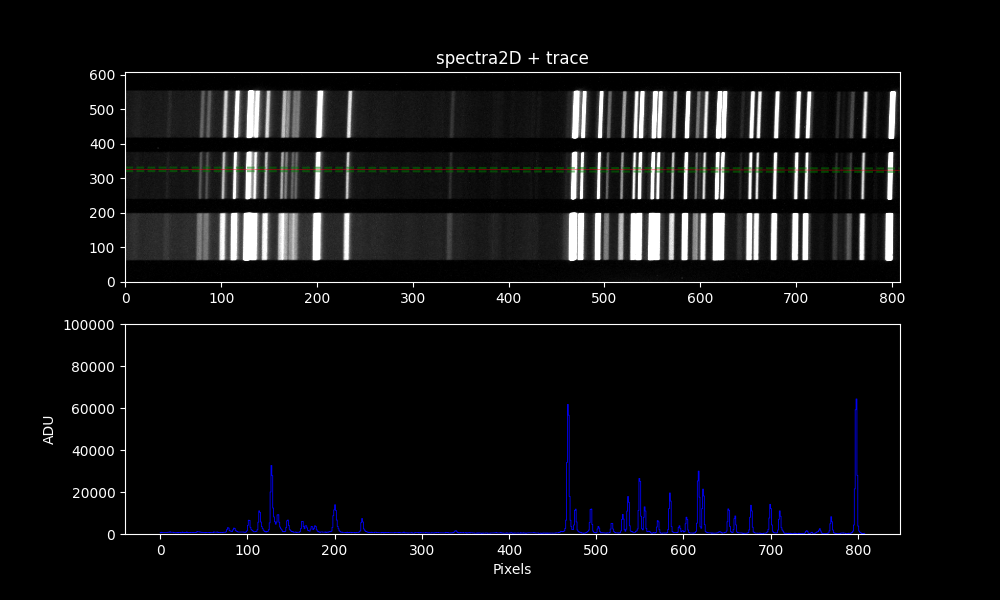

In [26]:
logger.info('extracting neon spectrum...')

neon_data = CCDData.read(CAPTURE_DIR + 'mastercalib.fit', unit = u.adu)

#specreduce.tracing.ArrayTrace(image: NDData, trace: ndarray)
#neon_tr = tracing.FlatTrace(neon_data,sci_tr.trace[int(sci_tr.shape[0] / 2.0)])   #FitTrace(image, peak_method='gaussian', guess=trace_pos)
#neon_tr = tracing.ArrayTrace(neon_data, sci_tr.trace[int(sci_tr.shape[0] / 2.0)])   #FitTrace(image, peak_method='gaussian', guess=trace_pos)
#bg = background.Background.two_sided(neon_data, sci_tr, separation=50, width=0) 
extract = BoxcarExtract(neon_data , sci_tr, width = 5)
neon_spectrum = extract()

cuts = (10, 75)
ax0, ax1 = plt.subplots(2, 1, figsize = (10,6))[1]
#plt.tight_layout()

im = ax0.imshow(neon_data, origin='lower', aspect='auto', cmap=plt.cm.grey)
#ax0.imshow(bg.bkg_wimage, origin='lower', aspect='auto', cmap=plt.cm.gray, alpha=0.1)
#ax0.imshow(sci_tr.image.data, origin='lower', aspect='auto', cmap=plt.cm.gray, alpha=1)
im.set_clim(np.percentile(master_science, cuts))
ax0.step(neon_spectrum.spectral_axis, sci_tr.trace , color='red', linewidth = '0.3')
ax0.step(neon_spectrum.spectral_axis, sci_tr.trace + extract.width , color='g', linestyle='dashed', alpha=0.5)
ax0.step(neon_spectrum.spectral_axis, sci_tr.trace - extract.width , color='g', linestyle='dashed', alpha=0.5)

ax0.set_title('spectra2D + trace')

ax1.step(neon_spectrum.spectral_axis , neon_spectrum.flux, color='blue', linewidth = '0.6')
ax1.set_xlabel('Pixels')
ax1.set_ylabel('ADU')
ax1.set_ylim(0, 0.1e6)

### identify lines
from specutils.fitting import find_lines_derivative
from specutils.fitting import fit_lines

lines = find_lines_derivative(neon_spectrum, flux_threshold=15000)
print('\nemission: \n', lines[lines['line_type'] == 'emission']) 
print('\nabsorption: \n', lines[lines['line_type'] == 'absorption']) 

# readjust x-pixel positions accordingly
#PIXELS = [78.099, 128.005, 200.651, 339.185, 468.038, 550.164, 617.539, 677.917, 796.963]*u.pix



### Calibrate calibration spectrum

2025-02-25 17:30:53 [INFO] - calibrating neon spectrum...
residuals : [ 0.54693633  0.83581987 -2.86893448  1.26793686  1.02932522  0.31789749
 -0.41537146 -1.38143866  0.66782882] Angstrom
fitted  Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
            c0                 c1                  c2          
         Angstrom        Angstrom / pix     Angstrom / pix2    
    ------------------ ----------------- ----------------------
    4236.0135213355225 3.371277747027985 0.00017151069626427013


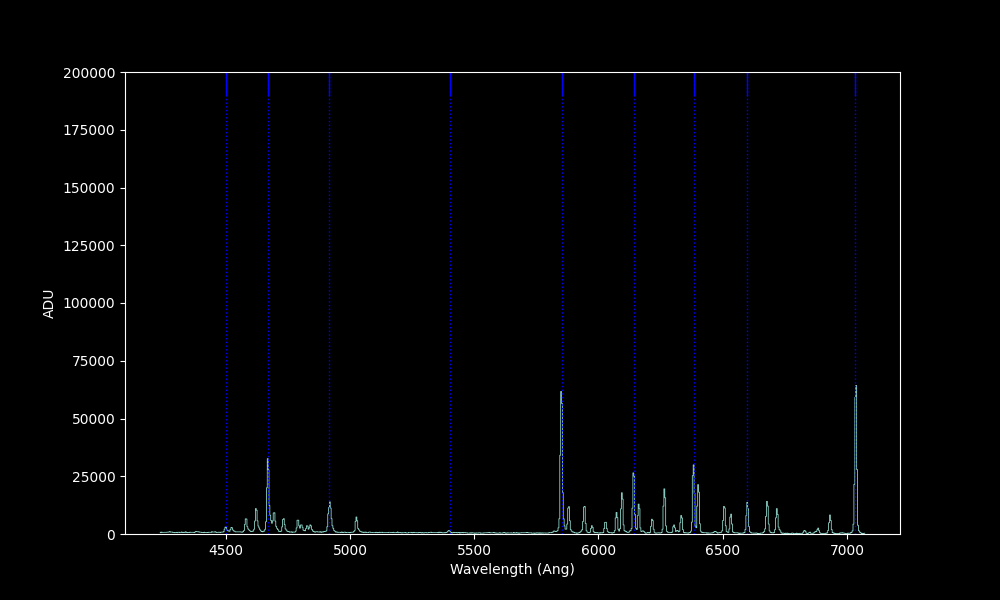

In [27]:
logger.info('calibrating neon spectrum...')

### alpy-600 + neon builtin
#pixels = [351, 589, 1045, 1403, 1885, 2073]*u.pix
#wavelength = [4200.67, 4764.87, 5852.49, 6677.28, 7272.94, 7635.11]*u.AA
#pixels =     [355,     1045,    1171     , 1284,   1406,      1535  , 1674  , 1840 ]*u.pix
#wavelength = [4200.67, 5852.49, 6143.06,  6402.25  , 6677.28  ,   6965.43 , 7272.94 , 7635.11]*u.AA
#wavelength_ = wavelength #= [4200.67, 5852.49, 6143.06,  6402.25  , 6677.28  ,   6965.43 , 7272.94 , 7635.11]

# Dados200 + Xenon lamp
#pixels = [191, 400, 871, 1105, 1533]*u.pix
#pixels = [188, 396, 868, 1102, 1530]*u.pix
#wavelength = [4671.22, 5028.28, 5852.49, 6266.49, 7031.41]*u.AA

### Dados200 + neon lamp
#pixels = [868, 1276, 2342, 3635, 4263]*u.pix
#wavelength = [6506.53, 6532.88, 6598.95, 6678.28, 6717.04]*u.AA

### StarEx-2400 + neon lamp
#pixels = [868, 1276, 2342, 3635, 4263]*u.pix
#pixels = [853, 1266, 2314, 3599, 4238]*u.pix
#wavelength = [6506.53, 6532.88, 6598.95, 6678.28, 6717.04]*u.AA
wavelength = WAVELENGTH
pixels = PIXELS

#line_list = QTable([pixels, wavelength], names=["pixel_center", "wavelength"])
#input_spectrum, matched_line_list=None, line_pixels=None, line_wavelengths=None, catalog=None, input_model=Linear1D(), fitter=None
cal = WavelengthCalibration1D(input_spectrum = neon_spectrum,
      #matched_line_list = line_list,
      line_wavelengths = wavelength,
      line_pixels = pixels,
      input_model = models.Polynomial1D(degree = 2),
      #fitter = fitting.LMLSQFitter()
      fitter = fitting.LinearLSQFitter()
     )
print('residuals :', cal.residuals )
print('fitted ', cal.fitted_model )

neon_calibrated_spectrum = cal.apply_to_spectrum(neon_spectrum)

plt.figure(figsize=(10,6))
plt.xlabel('Wavelength (Ang)')
plt.ylabel('ADU')
plt.step(neon_calibrated_spectrum.spectral_axis, neon_calibrated_spectrum.flux, linewidth = '0.6')  
for line in wavelength:
    plt.axvline(line.value, 0.95, 1.0, color = 'b', lw = 1.0)
    plt.axvline(line.value, color = 'b', lw = 1.0, linestyle = ':')
plt.ylim(0, 0.2e6);


### Apply to science spectrum

2025-02-25 17:31:02 [INFO] - calibrating science spectra...


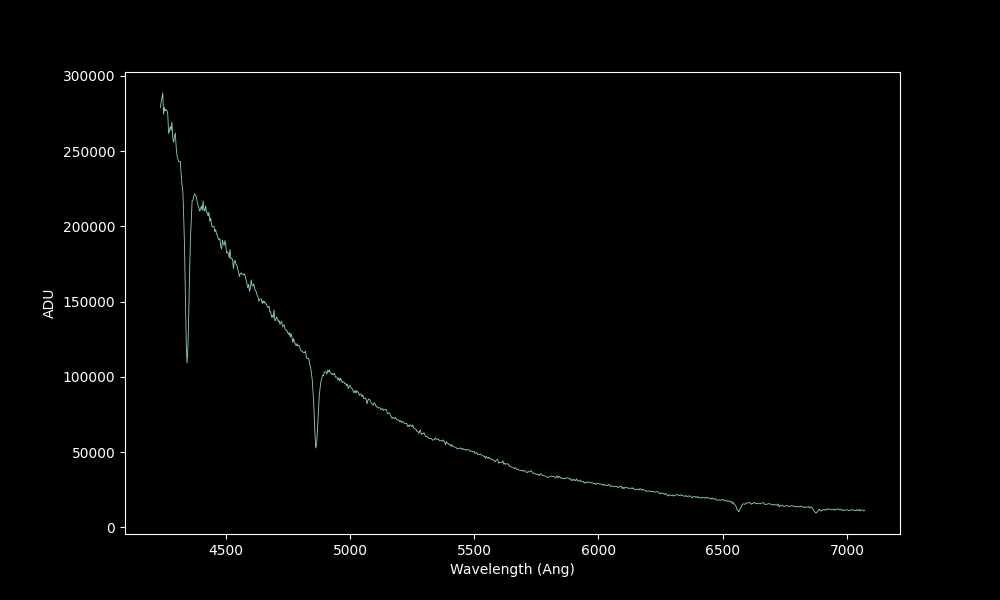

In [28]:
logger.info('calibrating science spectra...')
sci_calibrated_spectrum = cal.apply_to_spectrum(sci_spectrum)

plt.figure(figsize=(10,6))
plt.xlabel('Wavelength (Ang)')
plt.ylabel('ADU')
plt.plot(sci_calibrated_spectrum.wavelength, sci_calibrated_spectrum.flux, linewidth = '0.6');


### Smooth spectrum (optional)

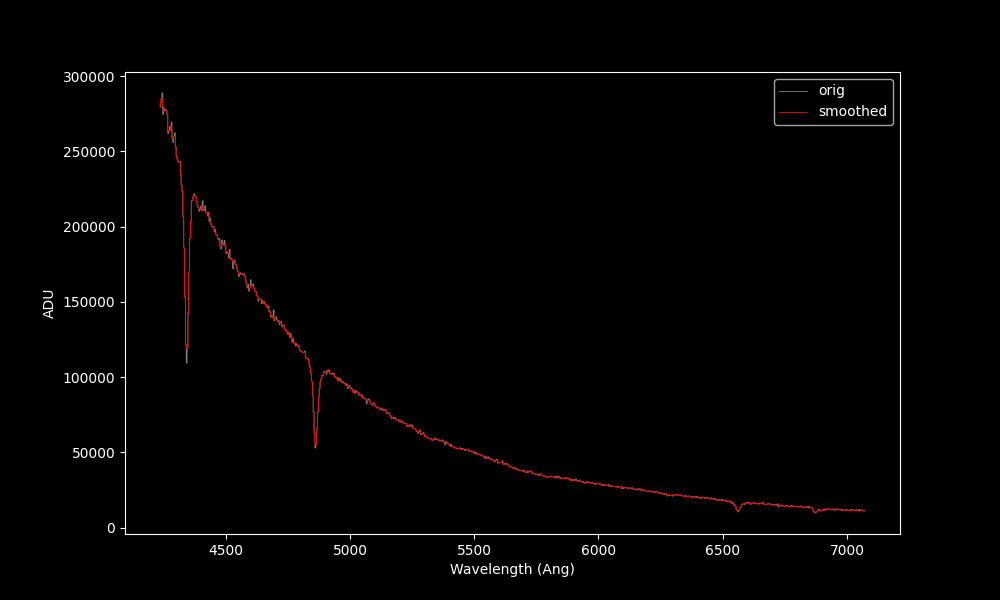

In [29]:
smooth_spec = median_smooth(sci_calibrated_spectrum, width = MEDIAN_SMOOTH) 

plt.figure(figsize=(10,6))
#plt.xlim(3000, 9000)
plt.xlabel('Wavelength (Ang)')
plt.ylabel('ADU')
plt.step(sci_calibrated_spectrum.wavelength, sci_calibrated_spectrum.flux + 100*u.adu, color = 'grey', linewidth = '0.6', label = 'orig')
plt.step(smooth_spec.wavelength, smooth_spec.flux , color = 'red', linewidth = '0.6', label = 'smoothed')
plt.legend(loc=('best'))

### decide to keep the median smoothed version ?
#sci_calibrated_spectrum = smooth_spec

sci_calibrated_spectrum.write(CAPTURE_DIR + TARGET + '-1D.fit', overwrite = True)


### Compute airmass

In [30]:
### compute zenith distance (if not present in fit header)
#TARGET = 'v558 lyr'
target_coord = SkyCoord.from_name(TARGET)
target_time = Time(master_science.header['DATE-OBS'])
obs_coord = EarthLocation(lon = OBS_LONGITUDE * u.deg, lat = OBS_LATITUDE * u.deg)
altaz = AltAz(obstime=target_time, location = obs_coord)

ZD = target_coord.transform_to(AltAz(obstime = target_time, location = obs_coord)).zen
airmass = 1.0 / np.cos(ZD)
logger.info(f'computed ZD={ZD}, airmass={airmass}')


2025-02-25 17:31:08 [INFO] - computed ZD=41.41456771188954 deg, airmass=1.333434845337585


### Correct instrument response

2025-02-25 17:48:27 [INFO] - reusing existing response file ... 
2025-02-25 17:48:27 [INFO] - response applied


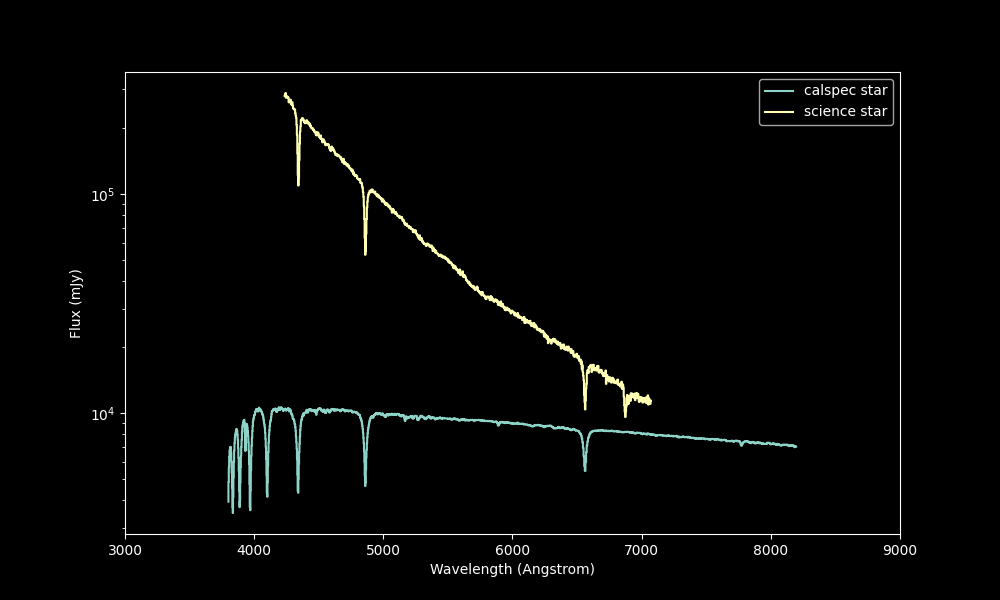

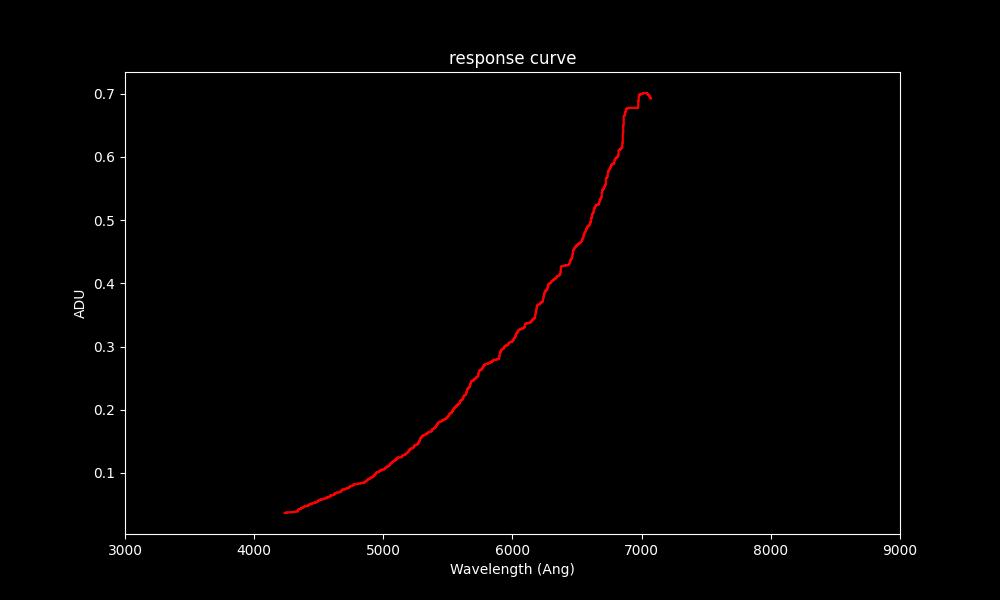

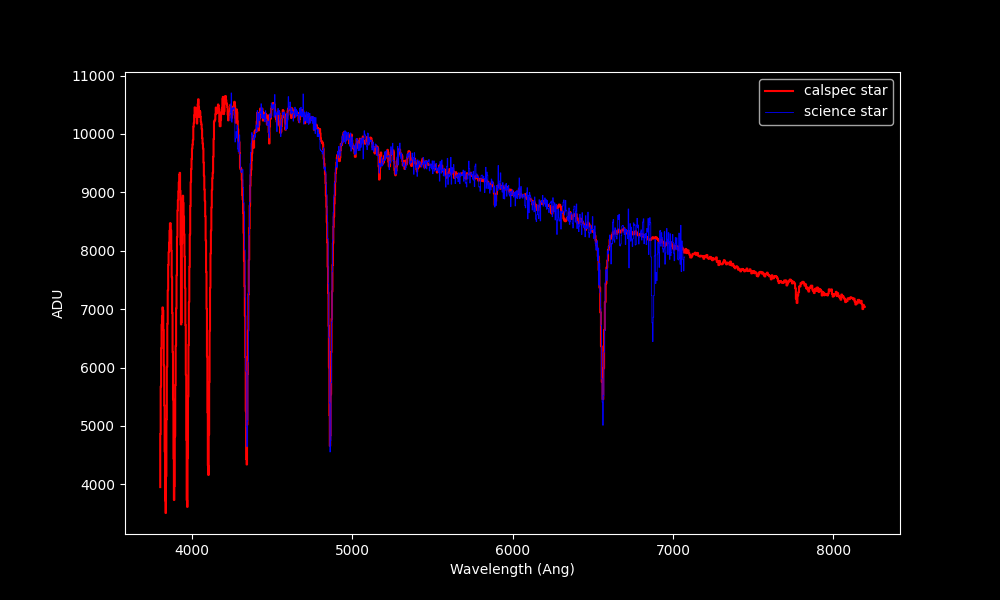

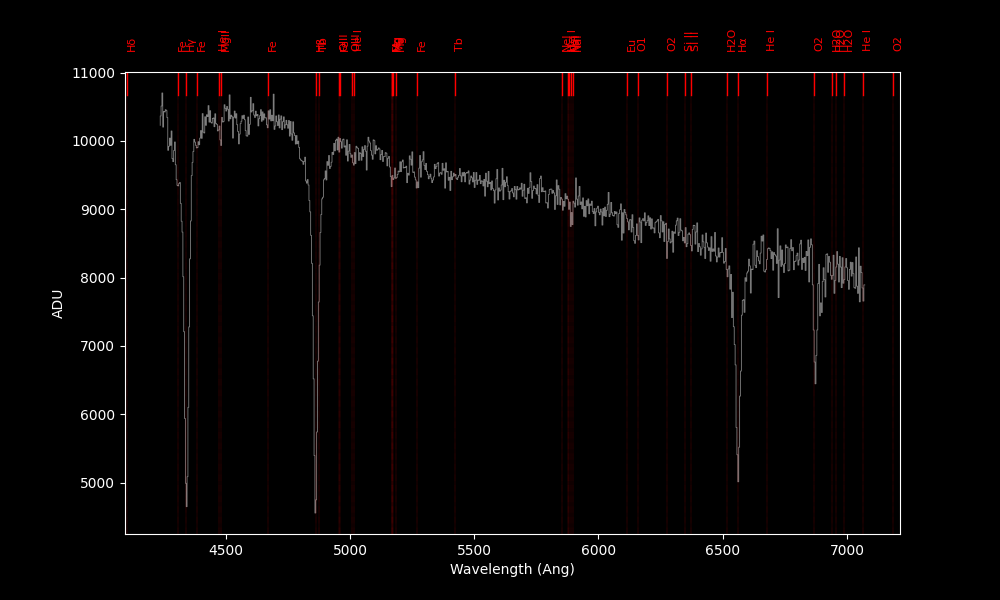

In [47]:
#std_spec = load_onedstds(dataset = 'spec50cal', specfile = 'hd217086.dat')
#std_spec = load_onedstds(dataset = 'bstdscal', specfile = 'hr5511.dat')
#std_spec = load_MAST_calspec("delumi_stis_004.fits")
#std_spec = load_MAST_calspec("bd60d1753_stiswfc_004.fits")
#std_spec = load_MAST_calspec("hd93521_stis_007.fits")         # O9Vp
#std_spec = load_MAST_calspec("hd101452_stis_004.fits")        # A2/3
#std_spec = load_MAST_calspec('etauma_stis_008.fits') # B3V

### load reference star from CALSPEC database
std_spec = load_MAST_calspec(REFERENCE_STAR)

### slice spectra to visible range
std_slice = std_spec[3800*u.AA:8200*u.AA]
sci_slice = sci_calibrated_spectrum[3800*u.AA:8200*u.AA]
final_spec = sci_slice

### show both spectra
fig, ax = plt.subplots(figsize=(10,6))
plt.xlim(WAVE_RANGE)     
ax.step(std_slice.spectral_axis, std_slice.flux, label = 'calspec star') #, where="mid"
ax.step(sci_slice.spectral_axis, sci_slice.flux, label = 'science star') # where="mid", 
ax.set_yscale('log')
ax.set_xlabel(f"Wavelength ({std_slice.spectral_axis.unit})")
ax.set_ylabel(f"Flux ({std_slice.flux.unit})");
plt.legend(loc=('best'))

#obj_spectrum = Spectrum1D(spectral_axis = sci_slice.spectral_axis, flux = sci_slice.flux)
#std_spectrum = Spectrum1D(spectral_axis = std_slice.spectral_axis, flux = std_slice.flux)
obj_spectrum = sci_slice
std_spectrum = std_slice

sci_spectrum = FluxCalibration(object_spectrum = obj_spectrum, airmass = airmass)
                
### reuse response file if exists
#if False:
if os.path.exists(CAPTURE_DIR + 'masterresponse.fit'):
    logger.info('reusing existing response file ... ')
    with fits.open(CAPTURE_DIR + 'masterresponse.fit') as resp:
        specdata = resp[1].data
        header = resp[1].header
        responsefunc = Spectrum1D(flux = specdata['flux']* u.mJy, spectral_axis = specdata['wavelength'] * u.AA)
        
        final_spec = sci_spectrum.apply_sensfunc(responsefunc)
    logger.info('response applied')
else:
    logger.info('creating a new response file ...')
    responsefunc = sci_spectrum.standard_sensfunc(
        standard = std_spectrum,
        mode = 'linear', #'linear', # 'poly', #'spline', 
        polydeg = 7,
        #badlines=[7516, 6880, 6844, 6860, 6920, 6563, 6566, 4861, 4341],
        display = False)
    logger.info('response created')

    ### smooth the response func ?
    #smooth_response = gaussian_smooth(responsefunc, stddev=3) 
    smooth_response = median_smooth(responsefunc, width=31) #2055) 
    responsefunc = smooth_response
    logger.info('response median smoothed')
        
    final_spec = sci_spectrum.apply_sensfunc(responsefunc)
    logger.info('response applied')

    responsefunc.write(CAPTURE_DIR + 'masterresponse.fit', overwrite = True)

#final_spec.write(CAPTURE_DIR + TARGET + '-1D.fit', overwrite = True)

plt.figure(figsize=(10,6))
plt.xlim(WAVE_RANGE)       # starEx2400

plt.xlabel('Wavelength (Ang)')
plt.ylabel('ADU')
plt.step(responsefunc.wavelength, responsefunc.flux, linewidth = '1.6', color = 'r');
plt.title('response curve')


plt.figure(figsize=(10,6))
plt.xlabel('Wavelength (Ang)')
plt.ylabel('ADU')
#plt.step(obj_spectrum.wavelength, obj_spectrum.flux, linewidth = '0.6', color = 'black');
plt.step(std_slice.wavelength, std_slice.flux, color = 'r', label = 'calspec star') #, where="mid", 
plt.step(final_spec.wavelength, final_spec.flux, linewidth = '0.6', color = 'b', label = 'science star'); #, where="mid",
plt.legend(loc=('best'))
#plt.step(std_spec.wavelength, std_spec.flux + 5000 * u.mJy, linewidth = '0.6', color = 'r')

from spec_utils import show_lines
plt.figure(figsize = (10,6))
plt.step(final_spec.wavelength, final_spec.flux, color='grey', linewidth = '0.6') #, where="mid")
plt.xlabel('Wavelength (Ang)')
plt.ylabel('ADU')
#plt.ylim(-10000, 1e6)

show_lines(ax = None, show_line = True)


### Normalize & save spectrum

In [52]:
### now export science spectrum (with header from 2D science frame)
### normalize spectra to 1
sci_mean_norm_region = final_spec[6000 * u.AA: 6200 * u.AA].flux.mean()        # DADOS200 : low resolution
#sci_mean_norm_region = final_spec[6500 * u.AA: 6520 * u.AA].flux.mean()       # starEx2400 : high resolution
final_spec = Spectrum1D(spectral_axis = final_spec.wavelength, flux = final_spec.flux / sci_mean_norm_region)  

### the FIT format save does not work : there is a shift of 8-10 Ang to every spec saved - no idea why ...
"""
with fits.open(CAPTURE_DIR + TARGET + '-reduced.fit') as scihead:
    hdr = scihead[0].header
    del hdr['NAXIS2']
    hdr['SIMPLE']  = 'T'
    hdr['BITPIX']  = -32 
    hdr['NAXIS']   = 1 
    hdr['CRPIX1']  = 1
    hdr['CTYPE1']  = 'Wavelength' #'Linear'
    hdr['CUNIT1']  = 'Angstrom'
    hdr['VERSION'] = 'EasyAstro - ' + __version__  
#    hdr['BSS_TELL'] = 'None'  
#    hdr['BSS_NORM'] = 'None'  
    hdr['CRVAL1']  = final_spec.wavelength[0].value
    hdr['CDELT1']  = (final_spec.wavelength[-1].value - final_spec.wavelength[0].value) / (len(final_spec.wavelength))
#    print(f'crval1={hdr["CRVAL1"]}, cdelt1={hdr["CDELT1"]}')
    hdr['OBJNAME'] = hdr['OBJECT'] 
    
    ### LEFT TO COMPUTE:
    #hdr['BSS_ITRP'] = 670
    #hdr['SPE_RPOW'] = 670
    #hdr['JD-OBS']  = '2460502.47465'
    
    fits.writeto(CAPTURE_DIR + TARGET + '-1D-final.fit', final_spec.data, header = hdr, overwrite=True)

final_spec.write(CAPTURE_DIR + TARGET + '-1D-final-tabular.fit', overwrite=True) #, format='tabular-fits')
"""

### save instead in simple 2-column .dat format - easy to open with fityk or Excel then
np.savetxt(CAPTURE_DIR + TARGET + '-1D-final-tabular.dat', np.array([final_spec.spectral_axis.value, final_spec.flux.value]).T)
